In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os

In [30]:
from scipy.spatial import cKDTree
from sklearn.neighbors import KDTree
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.multioutput import MultiOutputRegressor as MOR
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold, GridSearchCV, RepeatedKFold, cross_validate
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV
import xgboost as xgb
import warnings
from sklearn.cluster import KMeans, AffinityPropagation, MeanShift, SpectralClustering, AgglomerativeClustering,\
FeatureAgglomeration, Birch, OPTICS
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor

In [31]:
def RMSE(y_true, y_pred):
    'Normalized RMSE'
    RMSE = np.sqrt(((y_true - y_pred) ** 2).sum() / (y_true ** 2).sum())
    return RMSE

In [32]:
def plot(y_true, y_pred, border = 100):
    fig = plt.figure(figsize=(18,12))
    # set up subplot grid
    gridspec.GridSpec(2,2)
    
    #Big subplot with diagonal plot
    plt.subplot2grid((2,3), (0,0), colspan=2, rowspan=2)
    plt.xlim(0, border)
    plt.ylim(0, border)
    plt.scatter(y_true, y_pred,  s = 10)
    plt.plot([0, border], [0, border], c = 'red', alpha = 0.6)
    plt.plot([0, border * 1/1.15], [0, border], color = 'black', alpha = 0.6, linewidth = 2, linestyle = '--')
    plt.plot([0, border], [0, border * 0.85], color = 'black', alpha = 0.6, linewidth = 2, linestyle = '--')
    plt.xlabel('True values', fontsize = 20)
    plt.ylabel('Forecast values', fontsize = 20)
    plt.tick_params(labelsize = 20)
    plt.grid()

In [33]:
def CV_estimator_with_sigma(estimator, X, y):
    cv = RepeatedKFold(n_splits=4, n_repeats=5, random_state=3)
    scoring = {'r2': 'r2',
               'mae': 'neg_mean_absolute_error',
               'mse': 'neg_mean_squared_error',
               'n-rmse': make_scorer(RMSE, greater_is_better=False)
              } 
    scores = cross_validate(estimator, X, y, scoring=scoring, cv=cv, return_train_score=True)
    print('Model gives R2: %.3f +- %.3f' % (scores['test_r2'].mean(), 2*scores['test_r2'].std()))
    print('Model gives MAE: %.3f +- %.3f' % (abs(scores['test_mae']).mean(), 2*abs(scores['test_mae']).std()))
    print('Model gives MSE: %.3f +- %.3f' % (abs(scores['test_mse']).mean(), 2*abs(scores['test_mse']).std()))
    return scores

In [34]:
def optimal_params_search(estimator, params, X, y, scoring = 'r2'):
    param_grid = {}
    best_params = {}
    for i, param in enumerate(params):
        regr = estimator(**best_params)
        g_search = GridSearchCV(regr, param_grid = param, scoring=scoring, n_jobs=-1, cv=5)
        g_search.fit(X, y)
        best_params.update(g_search.best_params_)
    return best_params, g_search

In [35]:
path_gas_test = 'Geochemistry Data/CNS_gas_test.csv'
path_gas_train = 'Geochemistry Data/CNS_gas_train.csv'
path_oil = 'Geochemistry Data/CNS oil.csv'
path_rock_samples = 'Geochemistry Data/CNS rock samples.csv'
path_production_samples = 'Production Data/CNS_Field_Production.csv'

df_test = pd.read_csv(path_gas_test, skiprows = [1], header = 0)
df_train = pd.read_csv(path_gas_train, skiprows = [1], header = 0)
df_oil = pd.read_csv(path_oil, skiprows = [1], header = 0)
df_rock = pd.read_csv(path_rock_samples, skiprows = [1], header = 0)
df_prod = pd.read_csv(path_production_samples, skiprows = [1], header = 0)
df_train['WH_LONG'].iloc[-5] = df_train['WH_LONG'].iloc[-4]
df_train['WH_LONG'] = df_train['WH_LONG'].astype(float)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (0,1,2,3,4,5,8,9,15,17,20,21,22,23,24,25,27,28,29,30,31,32,33,34,36,42,43,44,46,47,48,56,57,58,92,93,99,100,101,102) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [57]:
coords_prod = df_prod[['X', 'Y']].drop_duplicates()
coords_prod = coords_prod.drop_duplicates()[(coords_prod['X'] > -2) & (coords_prod['Y'] < 58.6)]
coords_gas = df_train[['WH_LONG', 'WH_LAT']].drop_duplicates()
coords_oil = df_oil[['WH_LONG', 'WH_LAT']].drop_duplicates()
coords_rock = df_rock[['WH_LONG', 'WH_LAT']].drop_duplicates()

coords_prod.dropna(inplace = True)
coords_prod.reset_index(inplace = True, drop = True)
coords_gas.dropna(inplace = True)
coords_gas.reset_index(inplace = True, drop = True)
coords_oil.dropna(inplace = True)
coords_oil.reset_index(inplace = True, drop = True)
coords_rock.dropna(inplace = True)
coords_rock.reset_index(inplace = True, drop = True)

In [58]:
coords_rock.shape

(336, 2)

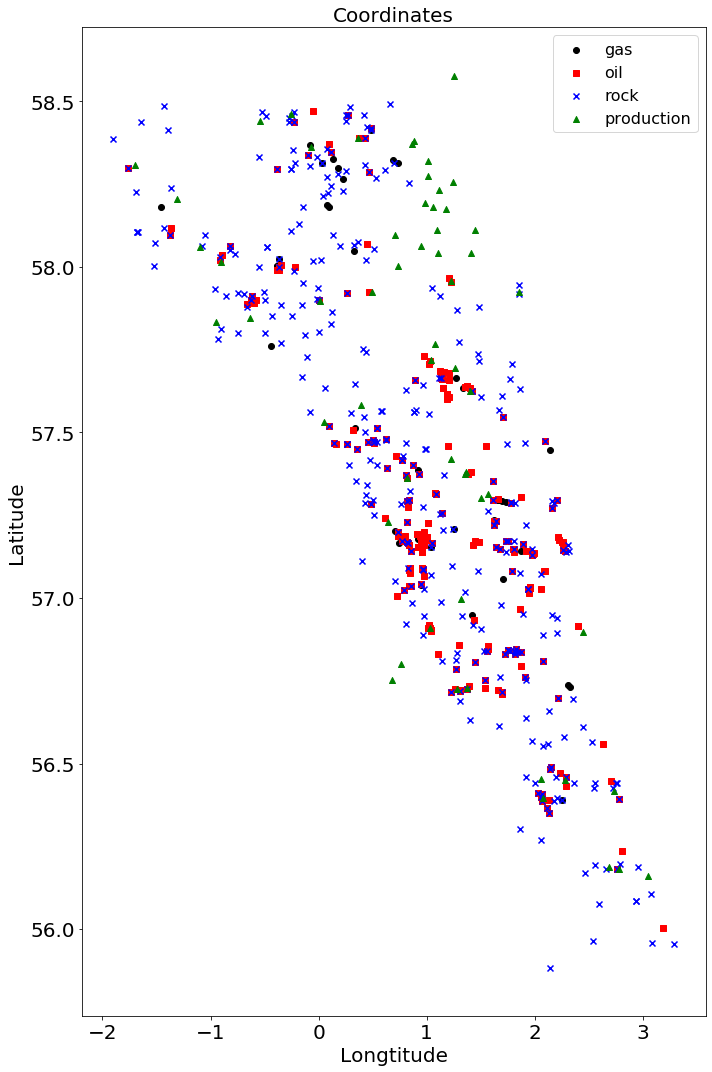

In [69]:
plt.figure(figsize = (10, 15))
df_train['WH_LONG'].iloc[-5] = df_train['WH_LONG'].iloc[-4]
df_train['WH_LONG'] = df_train['WH_LONG'].astype(float)
plt.scatter(coords_gas.iloc[:, 0], coords_gas.iloc[:, 1], color = 'black', label = 'gas')
plt.scatter(coords_oil.iloc[:, 0], coords_oil.iloc[:, 1], color = 'red', marker = 's', label = 'oil')
plt.scatter(coords_rock.iloc[:, 0], coords_rock.iloc[:, 1], color = 'blue', marker = 'x', label = 'rock')
plt.scatter(coords_prod.iloc[:, 0], coords_prod.iloc[:, 1], color = 'green', marker = '^', label = 'production')
plt.title('Coordinates', fontsize = 20)
plt.xlabel('Longtitude', fontsize = 20)
plt.ylabel('Latitude', fontsize = 20)
plt.tick_params(labelsize = 20)
plt.legend(fontsize = 16)
plt.savefig('wells.png')
plt.tight_layout()
plt.show()

In [60]:
df_prod['GAS_C1'] = None
df_prod['GAS_C2'] = None
df_prod['GAS_C3'] = None
df_prod['GAS_IC4'] = None
df_prod['GAS_NC4'] = None
df_prod['GAS_IC5'] = None
df_prod['GAS_NC5'] = None
df_prod['Target depth (m)'] = None

In [61]:
df_prod['OIL_PRPH'] = None
df_prod['OIL_PR17'] = None
df_prod['OIL_PH18'] = None
df_prod['OIL_CPI'] = None
df_prod['OIL_CPI_PH'] = None
df_prod['OIL_CPI_SS'] = None
df_prod['OIL_WAX'] = None
df_prod['Target depth (m)'] = None

In [87]:
tree_gas = KDTree(coords_gas, leaf_size=2)
tree_oil = KDTree(coords_oil, leaf_size=2)
tree_rock = KDTree(coords_rock, leaf_size=2)

In [116]:
import datetime
import calendar
import warnings
import tqdm
def add_months(sourcedate, months):
    month = sourcedate.month - 1 + months
    year = sourcedate.year + month // 12
    month = month % 12 + 1
    day = min(sourcedate.day, calendar.monthrange(year,month)[1])
    return datetime.date(year, month, day)

In [109]:
warnings.simplefilter('ignore')

In [90]:
df_train['SH_CDATE_upd'] = pd.to_datetime(df_train['SH_CDATE'], format='%d/%m/%Y %H:%M', errors='coerce')
mask = df_train['SH_CDATE_upd'].isnull()
df_train.loc[mask, 'SH_CDATE_upd'] = pd.to_datetime(df_train[mask]['SH_CDATE'],
                                                        format='%d-%m-%y %H:%M', errors='coerce')
df_train['SH_CDATE'] = df_train['SH_CDATE_upd']

df_train['SH_CDATE_upd'] = pd.to_datetime(df_train['SH_CDATE'], format='%d/%m/%Y %H:%M', errors='coerce')
mask = df_train['SH_CDATE_upd'].isnull()
df_train.loc[mask, 'SH_CDATE_upd'] = pd.to_datetime(df_train[mask]['SH_CDATE'],
                                                        format='%d-%m-%y %H:%M', errors='coerce')
df_train['SH_CDATE'] = df_train['SH_CDATE_upd']

In [100]:
df_train.dropna(subset=['SH_CDATE'], inplace = True)

In [101]:
df_train.shape

(1411, 92)

In [103]:
max(df_train['SH_CDATE'])

Timestamp('2018-01-27 00:00:00')

In [128]:
df_prod = df_prod[df_prod['OILPRODMAS'] > 0]

In [118]:
df_oil['SH_CDATE_upd'] = pd.to_datetime(df_oil['SH_CDATE'], format='%d-%b-%y', errors='coerce')
mask = df_oil['SH_CDATE_upd'].isnull()
df_oil.loc[mask, 'SH_CDATE_upd'] = pd.to_datetime(df_oil[mask]['SH_CDATE'],
                                                        format='%b %d, %Y', errors='coerce')

df_oil['SH_CDATE'] = df_oil['SH_CDATE_upd']

In [121]:
df_oil['SH_CDATE'].dropna(inplace = True)

In [136]:
for i in tqdm.tqdm_notebook(range(260, df_prod.shape[0])):
    coord = [df_prod[['X', 'Y']].iloc[i].values]
    dists, inds = tree_gas.query(coord, k=10)

    date = datetime.date(year = df_prod.iloc[i]['PERIODYR'],
                        month = df_prod.iloc[i]['PERIODMNTH'], 
                        day = 15)  
    before_date = add_months(date, -1)
    after_date = add_months(date, 1)
    
    #print(before_date, after_date)
    for col in ['GAS_C1', 'GAS_C2', 'GAS_C3', 'GAS_IC4', 'GAS_NC4', 'GAS_IC5', 'GAS_NC5']:
        val = 0
        counter = 0
        for ind in inds[0]:
            x_gas, y_gas = coords_gas['WH_LONG'].iloc[ind], coords_gas['WH_LAT'].iloc[ind]
            val_curr = df_train[(df_train['WH_LONG'] == x_gas) & (df_train['WH_LAT'] == y_gas) & (
                df_train['SH_CDATE'] > before_date) & ( df_train['SH_CDATE'] < after_date)][col]
            #print(df_train[(df_train['WH_LONG'] == x_gas) & (df_train['WH_LAT'] == y_gas)]['SH_CDATE'])
            if val_curr.shape[0] > 0:
                val += val_curr.values.mean()
                break
            #if counter > 4:
            #    val /= counter
            #    break
        #if counter > 0:
        #    val /= counter
        if val > 0: 
            df_prod[col].iloc[i] = val
        if val > 100:
            print(val)
            
    for col in ['OIL_PRPH', 'OIL_PR17', 'OIL_PH18', 'OIL_CPI', 'OIL_CPI_PH', 'OIL_CPI_SS', 'OIL_WAX']:
        val = 0
        counter = 0
        for ind in inds[0]:
            x_oil, y_oil = coords_oil['WH_LONG'].iloc[ind], coords_oil['WH_LAT'].iloc[ind]
            val_curr = df_oil[(df_oil['WH_LONG'] == x_oil) & (df_oil['WH_LAT'] == y_oil) & (
                df_oil['SH_CDATE'] > before_date) & (df_oil['SH_CDATE'] < after_date)][col]

            #print(df_train[(df_train['WH_LONG'] == x_gas) & (df_train['WH_LAT'] == y_gas)]['SH_CDATE'])
            if val_curr.shape[0] > 0:
                val += val_curr.values.mean()
                break
            #if counter > 4:
            #    val /= counter
            #    break
        #if counter > 0:
        #    val /= counter
        if val > 0: 
            df_prod[col].iloc[i] = val

In [122]:
# for i in tqdm.tqdm_notebook(range(df_prod.shape[0])):
#     coord = [df_prod[['X', 'Y']].iloc[i].values]
#     dists, inds = tree_oil.query(coord, k=10)

#     date = datetime.date(year = df_prod.iloc[i]['PERIODYR'],
#                         month = df_prod.iloc[i]['PERIODMNTH'], 
#                         day = 15)  
#     before_date = add_months(date, -1)
#     after_date = add_months(date, 1)
    
#     counter = 0
#     val = 0
#     for col in ['OIL_PRPH', 'OIL_PR17', 'OIL_PH18', 'OIL_CPI', 'OIL_CPI_PH', 'OIL_CPI_SS', 'OIL_WAX']:
#         for ind in inds[0]:
#             x_oil, y_oil = coords_oil['WH_LONG'].iloc[ind], coords_oil['WH_LAT'].iloc[ind]
#             val_curr = df_oil[(df_oil['WH_LONG'] == x_oil) & (df_oil['WH_LAT'] == y_oil) & (
#                 df_oil['SH_CDATE'] > before_date) & (df_oil['SH_CDATE'] < after_date)][col]

#             #print(df_train[(df_train['WH_LONG'] == x_gas) & (df_train['WH_LAT'] == y_gas)]['SH_CDATE'])
#             if val_curr.shape[0] > 0:
#                 val += val_curr.values.mean()
#             if counter > 4:
#                 val /= counter
#                 break
#         if val > 0: 
#             df_prod[col].iloc[i] = val

In [137]:
df_prod['TOC'] = None
df_prod['REV_TOTS1'] = None
df_prod['REV_TOTS2'] = None
df_prod['REV_TOTS3'] = None
df_prod['REV_TMAX'] = None
df_prod['H_INDEX'] = None
df_prod['O_INDEX'] = None
df_prod['P_INDEX'] = None

In [138]:
for i in tqdm.tqdm_notebook(range(df_prod.shape[0])):
    coord = [df_prod[['X', 'Y']].iloc[i].values]
    dists, inds = tree_rock.query(coord, k=10)
    for col in ['TOC', 'REV_TOTS1', 'REV_TOTS2', 'REV_TOTS3', 'REV_TMAX', 'H_INDEX', 'O_INDEX', 'P_INDEX']:
        counter = 0
        val = 0
        for ind in inds[0]:
            x_rock, y_rock = coords_rock['WH_LONG'].iloc[ind], coords_rock['WH_LAT'].iloc[ind]
            val_curr = df_rock[(df_rock['WH_LONG'] == x_rock) & (df_rock['WH_LAT'] == y_rock)][col]
            
            if val_curr.shape[0] > 0:
                val += val_curr.values.mean()
                break
        if val > 0: 
            df_prod[col].iloc[i] = val

In [139]:
df_prod.to_excel('filled.xlsx', index=False)

In [82]:
coord

[array([-1.46075907, 58.17926198])]

In [113]:
df_prod['GAS_C1'].iloc[0] = 

In [115]:
df_prod['GAS_C1'].dropna()

0              1
63          80.7
64          80.7
156         79.6
157         79.6
          ...   
11706     154.48
11707       73.9
11918       80.7
11919       80.7
11999    94.9242
Name: GAS_C1, Length: 343, dtype: object